In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from torch_fidelity import calculate_metrics
import shutil

In [9]:

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)


Using device: cuda:0


In [15]:

# Hyperparameters
image_size = 64
batch_size = 128
nz = 100       # Size of z latent vector (i.e., size of generator input)
num_epochs = 50
lr = 0.0002    # Learning rate for optimizers
beta1 = 0.5    # Beta1 hyperparameter for Adam optimizers

# Create output directories if they don't exist
os.makedirs('output_images_dcgan', exist_ok=True)
os.makedirs('generated_images_dcgan_epoch', exist_ok=True)
os.makedirs('real_images_dcgan', exist_ok=True)

# Transformation pipeline for the input data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

Files already downloaded and verified


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
    
            nn.ConvTranspose2d(nz, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
          
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
       
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
  
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
      
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
       
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
    
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []
FID_scores = []
FID_epochs = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)

        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] \
Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): \
{D_G_z1:.4f} / {D_G_z2:.4f}")

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            vutils.save_image(fake, f'output_images_dcgan/epoch_{epoch}_iter_{i}.png', normalize=True)

        iters += 1

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        netG.eval()  
        num_fake_images = 5000  
        fid_batch_size = 64

        fake_images_dir = f'generated_images_dcgan_epoch/epoch_{epoch+1}'
        os.makedirs(fake_images_dir, exist_ok=True)

        print(f"Generating fake images for FID computation at epoch {epoch+1}...")
        for i in range(0, num_fake_images, fid_batch_size):
            noise = torch.randn(fid_batch_size, nz, 1, 1, device=device)
            with torch.no_grad():
                fake_images = netG(noise).detach().cpu()
            for j in range(fake_images.size(0)):
                idx = i + j
                if idx >= num_fake_images:
                    break
                vutils.save_image(fake_images[j], f'{fake_images_dir}/fake_{idx}.png', normalize=True)

        real_images_dir = 'real_images_dcgan'
        if epoch == 0:
            os.makedirs(real_images_dir, exist_ok=True)
            print("Collecting real images for FID computation...")
            counter = 0
            for data in dataloader:
                images, _ = data
                for j in range(images.size(0)):
                    if counter >= num_fake_images:
                        break
                    vutils.save_image(images[j], f'{real_images_dir}/real_{counter}.png', normalize=True)
                    counter += 1
                if counter >= num_fake_images:
                    break
                
        # Compute FID score
        print(f"Computing FID score at epoch {epoch+1}...")
        metrics = calculate_metrics(
            input1=real_images_dir,
            input2=fake_images_dir,
            cuda=torch.cuda.is_available(),
            isc=False,
            fid=True,
            kid=False,
            verbose=False
        )

        fid_score = metrics['frechet_inception_distance']
        FID_scores.append(fid_score)
        FID_epochs.append(epoch + 1)

        print(f"Epoch [{epoch+1}/{num_epochs}] FID Score: {fid_score:.5f}")

        shutil.rmtree(fake_images_dir)

        netG.train() 

os.makedirs('final_images_dcgan', exist_ok=True)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
vutils.save_image(fake, 'final_images_dcgan/final_generated_images.png', normalize=True)

Starting Training Loop...
Epoch [1/50] Batch [0/391] Loss_D: 0.3510 Loss_G: 8.3315 D(x): 0.9054 D(G(z)): 0.2038 / 0.0007
Epoch [1/50] Batch [100/391] Loss_D: 0.3683 Loss_G: 2.7685 D(x): 0.8018 D(G(z)): 0.1162 / 0.0889
Epoch [1/50] Batch [200/391] Loss_D: 0.6130 Loss_G: 3.7675 D(x): 0.8033 D(G(z)): 0.2824 / 0.0326
Epoch [1/50] Batch [300/391] Loss_D: 1.7369 Loss_G: 9.3769 D(x): 0.9764 D(G(z)): 0.7309 / 0.0002
Epoch [2/50] Batch [0/391] Loss_D: 0.2656 Loss_G: 2.7755 D(x): 0.8121 D(G(z)): 0.0429 / 0.0855
Epoch [2/50] Batch [100/391] Loss_D: 0.8175 Loss_G: 2.7940 D(x): 0.7672 D(G(z)): 0.3728 / 0.0817
Epoch [2/50] Batch [200/391] Loss_D: 0.1754 Loss_G: 4.0239 D(x): 0.9564 D(G(z)): 0.1180 / 0.0231
Epoch [2/50] Batch [300/391] Loss_D: 0.3790 Loss_G: 2.4039 D(x): 0.7715 D(G(z)): 0.0851 / 0.1156
Epoch [3/50] Batch [0/391] Loss_D: 0.5446 Loss_G: 1.7958 D(x): 0.6849 D(G(z)): 0.1075 / 0.2195
Epoch [3/50] Batch [100/391] Loss_D: 1.0426 Loss_G: 4.4509 D(x): 0.9499 D(G(z)): 0.5769 / 0.0159
Epoch [3/5

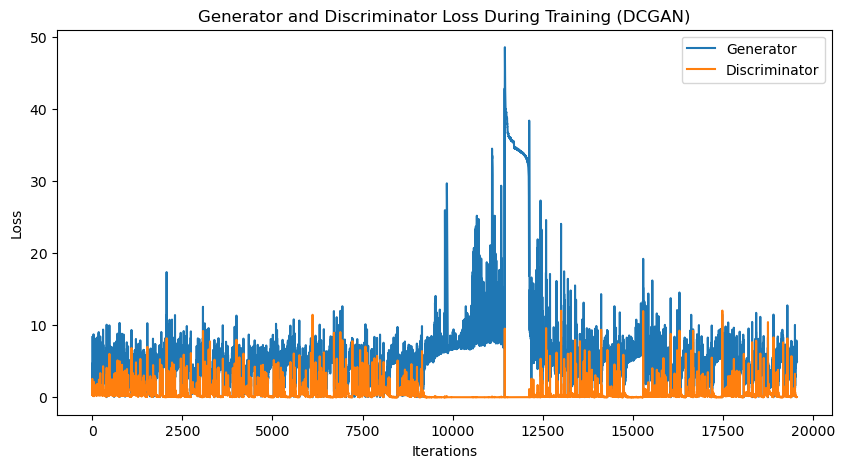

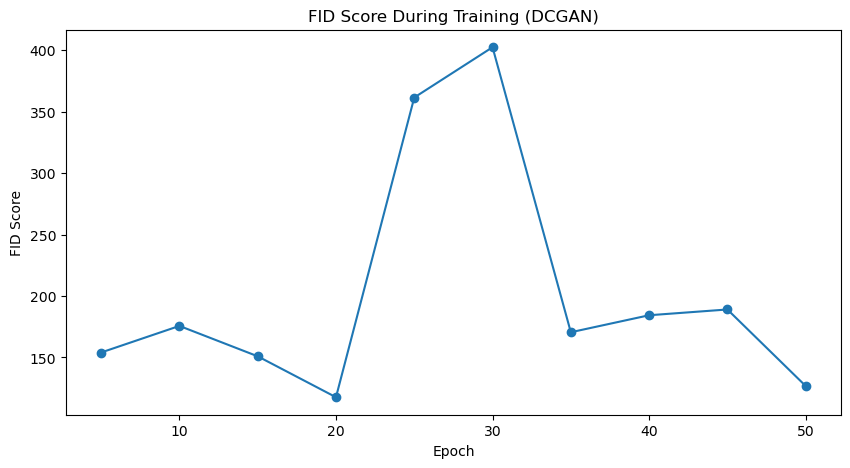

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (DCGAN)")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("FID Score During Training (DCGAN)")
plt.plot(FID_epochs, FID_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.show()

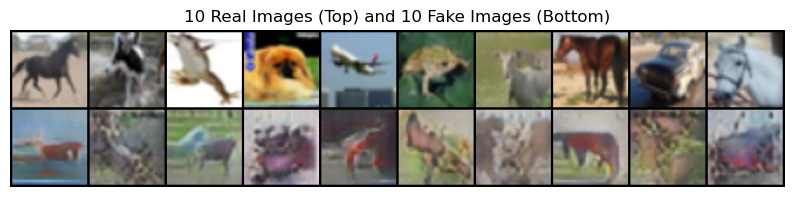

In [ ]:
import torchvision.utils as vutils

noise = torch.randn(10, 100, 1, 1, device=device) 
fake_images = netG(noise).detach().cpu()

real_images = next(iter(dataloader))[0][:10].cpu()

comparison_images = torch.cat([real_images, fake_images])

plt.figure(figsize=(10, 5))
plt.axis("off")
plt.title("10 Real Images (Top) and 10 Fake Images (Bottom)")
plt.imshow(vutils.make_grid(comparison_images, nrow=10, normalize=True).permute(1, 2, 0))
plt.show()